# Allocate renewable resources to the bus

Convert CRS from ESPG:4326 (lat/lon) to ESPG:32618 (UTM 18N)

Nearest neighbor distance calculation in meters.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx
from shapely.geometry import LineString
from nygrid.allocate import nearest_neighbor_meters
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

gis_data_dir = os.path.join(data_dir, 'gis')
if not os.path.exists(gis_data_dir):
    raise FileNotFoundError('GIS data directory not found.')

print('GIS data directory: {}'.format(gis_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))


GIS data directory: /home/by276/models/NYgrid-python/data/gis
Figure directory: /home/by276/models/NYgrid-python/figures


## NY Grid

In [3]:
# Read shapefile of NYISO zone map
nyiso_zone = gpd.read_file(os.path.join(gis_data_dir, 'NYISO Load Zone.shp'))
nyiso_zone = nyiso_zone.set_index('FID')
nyiso_zone_32618 = nyiso_zone.to_crs(epsg=32618)

# Read shapefile of NYGrid buses
nygrid_bus = gpd.read_file(os.path.join(gis_data_dir, 'Bus.shp'))
nygrid_bus = nygrid_bus.set_index('fid')
# Drop columns that are not needed
nygrid_bus = nygrid_bus[['busIdx', 'busType', 'zone', 'geometry']]
# Convert bus type to category
nygrid_bus['busType'] = pd.Categorical(nygrid_bus['busType'])
nygrid_bus_32618 = nygrid_bus.to_crs(epsg=32618)

# Filter out external buses
nygrid_bus_ny = nygrid_bus[nygrid_bus['zone'] != 0]
nygrid_bus_ny_32618 = nygrid_bus_ny.to_crs(epsg=32618)

# Read shapefile of NYGrid branches
nygrid_branch = gpd.read_file(os.path.join(gis_data_dir, 'Branch.shp'))
nygrid_branch_32618 = nygrid_branch.to_crs(epsg=32618)

# Read shapefile of NYGrid generators
nygrid_generator = gpd.read_file(os.path.join(gis_data_dir, 'Generator.shp'))
nygrid_generator_32618 = nygrid_generator.to_crs(epsg=32618)


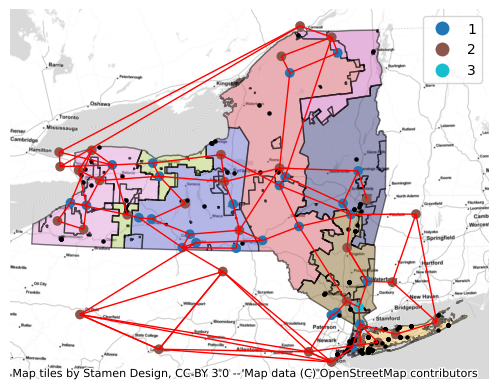

In [4]:
# NYISO zone map
ax = nyiso_zone_32618.plot('ZONE_NAME', cmap='tab20b',
                           alpha=0.5, edgecolor='k')

# NYGrid buses, branches, and generators
nygrid_bus_32618.plot(ax=ax, column='busType', legend=True)
nygrid_branch_32618.plot(ax=ax, color='red', linewidth=1)
nygrid_generator_32618.plot(ax=ax, color='black', markersize=5)

cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite,
               crs=nygrid_bus_32618.crs)
ax.set_axis_off()


## Thermal generators

In [5]:
# Read thermal generator locations
gen_info = pd.read_csv(os.path.join(data_dir,
                                    'genInfo.csv'))
# Turn into geodataframe
gen_info = gpd.GeoDataFrame(gen_info,
                            geometry=gpd.points_from_xy(gen_info.Longitude,
                                                        gen_info.Latitude),
                            crs='EPSG:4326')
# Set CRS
gen_info = gen_info.set_crs(epsg=4326)
gen_info_32618 = gen_info.to_crs(epsg=32618)

gen_info.head()


,NYISOName,PTID,Zone,UnitType,FuelType,Latitude,Longitude,maxPower,minPower,maxRampAgc,maxRamp10,maxRamp30,maxRamp60,HeatRateLM_R2,HeatRateQM_R2,BusName,NCOST,cost_1,cost_0,geometry
0,Allegany,23514,B,Combined Cycle,Natural Gas,42.5083,-78.0661,66.0,11.0,0.733333,7.333333,22.00,44.0,0.862443,0.891407,62,1,22.682017,-40.234372,POINT (-78.06610 42.50830)
1,Arthur Kill ST 2,23512,J,Steam Turbine,Natural Gas,40.5915,-74.2027,349.0,96.0,2.850000,28.500000,85.50,171.0,0.995837,0.995860,82,1,25.306225,736.980064,POINT (-74.20270 40.59150)
2,Arthur Kill ST 3,23513,J,Steam Turbine,Natural Gas,40.5915,-74.2027,539.0,1.0,3.108333,31.083333,93.25,186.5,0.986235,0.991460,82,1,25.957282,993.894899,POINT (-74.20270 40.59150)
3,Astoria 2,24149,J,Steam Turbine,Natural Gas,40.7869,-73.9122,153.0,1.0,0.808333,8.083333,24.25,48.5,0.987563,0.988910,82,1,31.302863,430.832898,POINT (-73.91220 40.78690)
4,Astoria 3,23516,J,Steam Turbine,Fuel Oil 2,40.7869,-73.9122,756.0,40.0,6.033333,60.333333,181.00,362.0,0.996075,0.996269,82,1,66.084194,3680.943877,POINT (-73.91220 40.78690)


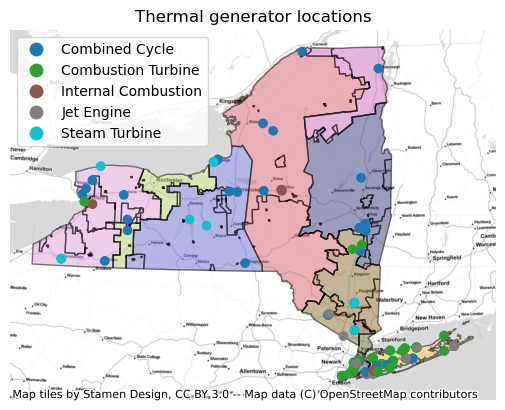

In [6]:
# Shop locations in a map
ax = nyiso_zone_32618.plot('ZONE_NAME', cmap='tab20b',
                           alpha=0.5, edgecolor='k')
ax = gen_info_32618.plot(ax=ax, column='UnitType', legend=True)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite,
               crs=gen_info_32618.crs)
ax.title.set_text('Thermal generator locations')
ax.set_axis_off()


## Current solar farms

In [7]:
# Read solar farm locations
# Read current solar farm locations (aggregated by zip code)
current_solar_info = pd.read_csv(os.path.join(data_dir,
                                              'solar',
                                              'solar_farms.csv'))
# Turn into geodataframe
current_solar_info = gpd.GeoDataFrame(current_solar_info,
                                      geometry=gpd.points_from_xy(current_solar_info.longitude,
                                                                  current_solar_info.latitude))
# Set CRS
current_solar_info = current_solar_info.set_crs(epsg=4326)
current_solar_info_32618 = current_solar_info.to_crs(epsg=32618)

current_solar_info


,zip_code,totalnameplatekwdc,latitude,longitude,geometry
0,10001,62.44,42.4561,-73.9277,POINT (-73.92770 42.45610)
1,10002,1420.19,42.7063,-74.0193,POINT (-74.01930 42.70630)
2,10003,191.47,42.6108,-74.1466,POINT (-74.14660 42.61080)
3,10004,38.28,42.5759,-73.9640,POINT (-73.96400 42.57590)
4,10007,11.07,42.4757,-73.7977,POINT (-73.79770 42.47570)
...,...,...,...,...,...
1611,14898,36.67,40.6102,-74.0878,POINT (-74.08780 40.61020)
1612,14901,492.58,40.5973,-74.0768,POINT (-74.07680 40.59730)
1613,14903,5318.50,40.5682,-74.1184,POINT (-74.11840 40.56820)
1614,14904,17.55,40.5085,-74.2445,POINT (-74.24450 40.50850)


In [8]:
# Nearest neighbor allocation
closest_bus = nearest_neighbor_meters(current_solar_info_32618,
                                      nygrid_bus_ny_32618,
                                      return_dist=True)

# Rename the geometry of closest stops gdf so that we can easily identify it
closest_bus = closest_bus.rename(columns={'geometry': 'closest_bus_geom'})

# Merge the datasets by index (for this, it is good to use '.join()' -function)
current_solar_info_2bus_32618 = current_solar_info_32618.join(closest_bus)

# Create a link (LineString) between building and stop points
current_solar_info_2bus_32618['link'] = current_solar_info_2bus_32618.apply(
    lambda row: LineString([row['geometry'], row['closest_bus_geom']]), axis=1)

# Set link as the active geometry
current_solar_info_links_32618 = current_solar_info_2bus_32618.copy()
current_solar_info_links_32618 = current_solar_info_links_32618.set_geometry(
    'link').set_crs(epsg=32618)

# Save the allocation to CSV
current_solar_info_2bus_32618.to_csv(os.path.join(data_dir,
                                                  'solar',
                                                  'solar_farms_2bus.csv'))


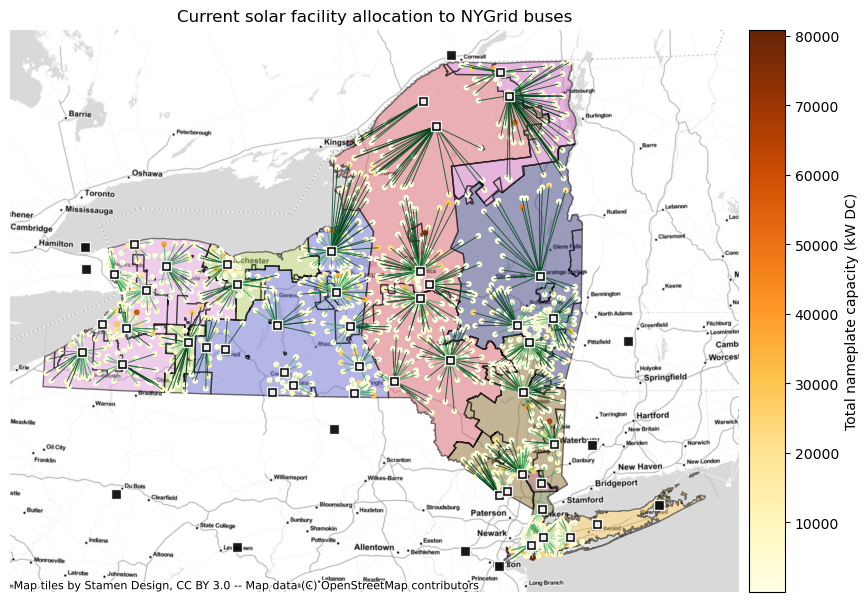

In [9]:
# Plot the connecting links between buildings and stops and color them based on distance
fig, ax = plt.subplots(figsize=(10, 8))

# Colorbar axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax = nyiso_zone_32618.plot(ax=ax, column='ZONE_NAME',
                           cmap='tab20b', alpha=0.5, edgecolor='k')

ax = nygrid_bus_32618.plot(ax=ax, markersize=50, marker='s',
                           color='k', edgecolor='w', alpha=0.9, zorder=9)
ax = nygrid_bus_ny_32618.plot(ax=ax, markersize=10, marker='s',
                              color='w', alpha=0.9, zorder=10)

ax = current_solar_info_32618.plot(column='totalnameplatekwdc', cmap='YlOrBr',
                                   legend=True, ax=ax, cax=cax, markersize=10,
                                   legend_kwds={'label': 'Total nameplate capacity (kW DC)'})

ax = current_solar_info_links_32618.plot(ax=ax, column='distance', cmap='Greens',
                                         scheme='quantiles', k=4, alpha=0.8, lw=0.7)

cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite,
               crs=current_solar_info_32618.crs)
ax.title.set_text('Current solar facility allocation to NYGrid buses')
ax.set_axis_off()
fig.savefig(os.path.join(fig_dir, 'current_solar_allocation.png'), dpi=300,
            bbox_inches='tight')


## Future solar farms

In [10]:
# Read future solar farm locations
future_solar_info = pd.read_csv(os.path.join(data_dir,
                                             'solar',
                                             'future_solar_farms.csv'),
                                index_col=0)
# Turn into geodataframe
future_solar_info = gpd.GeoDataFrame(future_solar_info,
                                     geometry=gpd.points_from_xy(future_solar_info.longitude,
                                                                 future_solar_info.latitude))
# Set CRS
future_solar_info = future_solar_info.set_crs(epsg=4326)
future_solar_info_32618 = future_solar_info.to_crs(epsg=32618)

future_solar_info


,index,FID,longitude,latitude,Zone,Local Population Density,Acres,Site Size,Site Capacity,totalnameplatekwdc,geometry
0,3245,3245,-73.639811,40.688801,K,7859.594717,218.336956,0.883579,34.459585,34459.584672,POINT (-73.63981 40.68880)
1,3246,3246,-73.632720,40.696226,K,7802.735292,33.558074,0.135805,5.296388,5296.388271,POINT (-73.63272 40.69623)
2,3244,3244,-73.664500,40.625916,K,6998.219315,73.167635,0.296099,11.547868,11547.867851,POINT (-73.66450 40.62592)
3,3243,3243,-73.667721,40.612932,K,6948.505825,11.350832,0.045935,1.791474,1791.473873,POINT (-73.66772 40.61293)
4,7209,7210,-73.530395,40.686001,K,6589.101675,16.397505,0.066358,2.587978,2587.977827,POINT (-73.53039 40.68600)
...,...,...,...,...,...,...,...,...,...,...,...
526,8442,8447,-78.768565,42.845054,A,2676.096825,12.792536,0.051770,2.019015,2019.014550,POINT (-78.76856 42.84505)
527,8665,8670,-78.719455,42.913722,A,2667.101544,121.839635,0.493068,19.229650,19229.649788,POINT (-78.71945 42.91372)
528,8373,8378,-78.839288,42.817331,A,2666.119172,10.008236,0.040502,1.579575,1579.575283,POINT (-78.83929 42.81733)
529,9086,9091,-78.809087,43.024827,A,2654.564904,12.022361,0.048653,1.897460,1897.459671,POINT (-78.80909 43.02483)


In [11]:
# Nearest neighbor allocation to NYGrid buses
closest_bus = nearest_neighbor_meters(future_solar_info_32618,
                                      nygrid_bus_ny_32618,
                                      return_dist=True)

# Rename the geometry of closest stops gdf so that we can easily identify it
closest_bus = closest_bus.rename(columns={'geometry': 'closest_bus_geom'})

# Merge the datasets by index (for this, it is good to use '.join()' -function)
future_solar_info_2bus_32618 = future_solar_info_32618.join(closest_bus)

# Create a link (LineString) between building and stop points
future_solar_info_2bus_32618['link'] = future_solar_info_2bus_32618.apply(
    lambda row: LineString([row['geometry'], row['closest_bus_geom']]), axis=1)

# Set link as the active geometry
future_solar_info_links_32618 = future_solar_info_2bus_32618.copy()
future_solar_info_links_32618 = future_solar_info_links_32618.set_geometry(
    'link').set_crs(epsg=32618)

# Save the allocation to CSV
future_solar_info_2bus_32618.to_csv(os.path.join(data_dir,
                                    'solar',
                                                 'future_solar_farms_2bus.csv'))


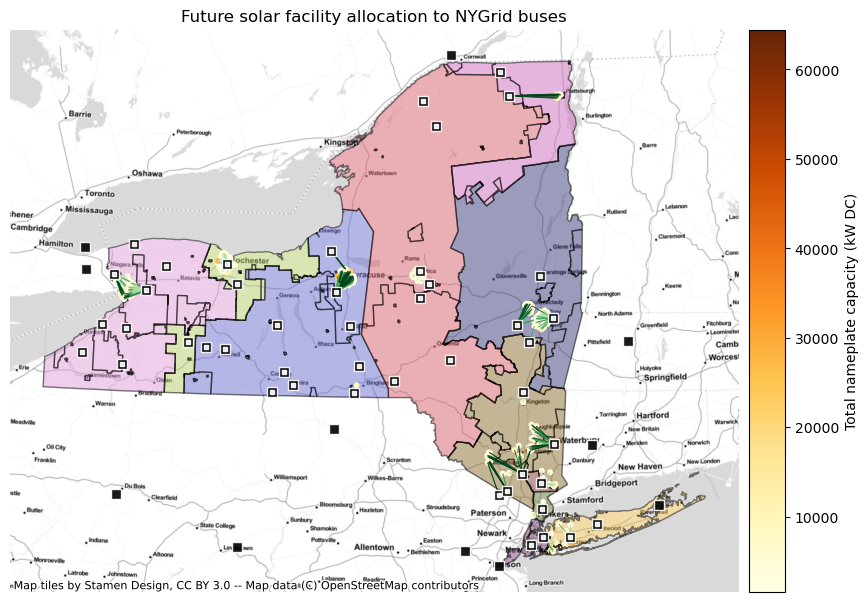

In [12]:
# Plot the connecting links between buildings and stops and color them based on distance
fig, ax = plt.subplots(figsize=(10, 8))

# Colorbar axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax = nyiso_zone_32618.plot(ax=ax, column='ZONE_NAME',
                           cmap='tab20b', alpha=0.5, edgecolor='k')

ax = nygrid_bus_32618.plot(ax=ax, markersize=50, marker='s',
                           color='k', edgecolor='w', alpha=0.9, zorder=9)
ax = nygrid_bus_ny_32618.plot(ax=ax, markersize=10, marker='s',
                              color='w', alpha=0.9, zorder=10)

ax = future_solar_info_32618.plot(column='totalnameplatekwdc', cmap='YlOrBr',
                                  legend=True, ax=ax, cax=cax, markersize=10,
                                  legend_kwds={'label': 'Total nameplate capacity (kW DC)'})

ax = future_solar_info_links_32618.plot(ax=ax, column='distance', cmap='Greens',
                                        scheme='quantiles', k=4, alpha=0.8, lw=0.7)

cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite,
               crs=future_solar_info_32618.crs)
ax.title.set_text('Future solar facility allocation to NYGrid buses')
ax.set_axis_off()
fig.savefig(os.path.join(fig_dir, 'future_solar_allocation.png'), dpi=300,
            bbox_inches='tight')


## Onshore wind

In [13]:
# Read onshore wind turbine locations
onshore_wind_info = pd.read_csv(os.path.join(data_dir,
                                             'onshore_wind',
                                             'uswtdb_ny.csv'))

# Turn into geodataframe
onshore_wind_info = gpd.GeoDataFrame(onshore_wind_info,
                                     geometry=gpd.points_from_xy(onshore_wind_info.xlong,
                                                                 onshore_wind_info.ylat),
                                     crs=4326)
onshore_wind_info_32618 = onshore_wind_info.to_crs(epsg=32618)

onshore_wind_info


,case_id,faa_ors,faa_asn,usgs_pr_id,t_state,t_county,t_fips,p_name,p_year,p_tnum,...,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat,eia_id,retrofit,retrofit_year,geometry
0,3075458,36-123728,2013-WTE-439-OE,NaN,NY,Chautauqua County,36013,Arkwright Summit,2018.0,36,...,3,3,9/1/2018,Digital Globe,-79.20978,42.38207,61673.0,0,NaN,POINT (-79.20978 42.38207)
1,3075483,36-123754,2016-WTE-8733-OE,NaN,NY,Chautauqua County,36013,Arkwright Summit,2018.0,36,...,3,3,9/1/2018,Digital Globe,-79.22976,42.42740,61673.0,0,NaN,POINT (-79.22976 42.42740)
2,3075490,36-123761,2016-WTE-8740-OE,NaN,NY,Chautauqua County,36013,Arkwright Summit,2018.0,36,...,3,3,9/1/2018,Digital Globe,-79.24846,42.42875,61673.0,0,NaN,POINT (-79.24846 42.42875)
3,3075459,36-123729,2016-WTE-10287-OE,NaN,NY,Chautauqua County,36013,Arkwright Summit,2018.0,36,...,3,3,9/18/2018,Digital Globe,-79.21964,42.38646,61673.0,0,NaN,POINT (-79.21964 42.38646)
4,3075465,36-123735,2013-WTE-461-OE,NaN,NY,Chautauqua County,36013,Arkwright Summit,2018.0,36,...,3,3,9/1/2018,Digital Globe,-79.25908,42.42524,61673.0,0,NaN,POINT (-79.25908 42.42524)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212,3124539,36-197731,2019-WTE-9476-OE,NaN,NY,Steuben County,36101,unknown Steuben County,NaN,11,...,1,1,1/31/2022,Digital Globe,-77.51514,42.47650,NaN,0,NaN,POINT (-77.51514 42.47650)
1213,3124566,36-197734,2019-WTE-9483-OE,NaN,NY,Steuben County,36101,unknown Steuben County,NaN,11,...,1,1,10/28/2021,Digital Globe,-77.54897,42.48269,NaN,0,NaN,POINT (-77.54897 42.48269)
1214,3124621,36-197735,2019-WTE-9484-OE,NaN,NY,Steuben County,36101,unknown Steuben County,NaN,11,...,1,1,10/28/2021,Digital Globe,-77.55095,42.48731,NaN,0,NaN,POINT (-77.55095 42.48731)
1215,3124638,36-197730,2019-WTE-9473-OE,NaN,NY,Steuben County,36101,unknown Steuben County,NaN,11,...,1,1,10/28/2021,Digital Globe,-77.52970,42.50448,NaN,0,NaN,POINT (-77.52970 42.50448)


In [14]:
# Nearest neighbor allocation
closest_bus = nearest_neighbor_meters(onshore_wind_info_32618,
                                      nygrid_bus_ny_32618,
                                      return_dist=True)

# Rename the geometry of closest stops gdf so that we can easily identify it
closest_bus = closest_bus.rename(columns={'geometry': 'closest_bus_geom'})

# Merge the datasets by index (for this, it is good to use '.join()' -function)
onshore_wind_info_2bus_32618 = onshore_wind_info_32618.join(closest_bus)

# Create a link (LineString) between building and stop points
onshore_wind_info_2bus_32618['link'] = onshore_wind_info_2bus_32618.apply(
    lambda row: LineString([row['geometry'], row['closest_bus_geom']]), axis=1)

# Set link as the active geometry
onshore_wind_info_links_32618 = onshore_wind_info_2bus_32618.copy()
onshore_wind_info_links_32618 = onshore_wind_info_links_32618.set_geometry(
    'link').set_crs(epsg=32618)

# Save the allocation to CSV
onshore_wind_info_2bus_32618.to_csv(os.path.join(data_dir,
                                    'onshore_wind',
                                                 'onshore_wind_2bus.csv'))


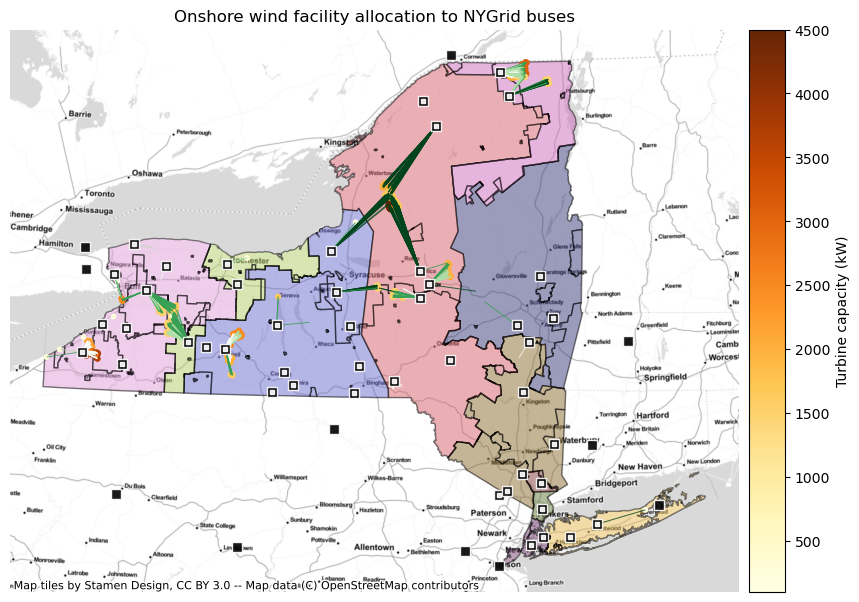

In [15]:
# Plot the connecting links between buildings and stops and color them based on distance
fig, ax = plt.subplots(figsize=(10, 8))

# Colorbar axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax = nyiso_zone_32618.plot(ax=ax, column='ZONE_NAME',
                           cmap='tab20b', alpha=0.5, edgecolor='k')

ax = nygrid_bus_32618.plot(ax=ax, markersize=50, marker='s',
                           color='k', edgecolor='w', alpha=0.9, zorder=9)
ax = nygrid_bus_ny_32618.plot(ax=ax, markersize=10, marker='s',
                              color='w', alpha=0.9, zorder=10)

ax = onshore_wind_info_32618.plot(column='t_cap', cmap='YlOrBr',
                                  legend=True, ax=ax, cax=cax, markersize=10,
                                  legend_kwds={'label': 'Turbine capacity (kW)'})

ax = onshore_wind_info_links_32618.plot(ax=ax, column='distance', cmap='Greens',
                                        scheme='quantiles', k=4, alpha=0.8, lw=0.7)

cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite,
               crs=onshore_wind_info_32618.crs)
ax.title.set_text('Onshore wind facility allocation to NYGrid buses')
ax.set_axis_off()
fig.savefig(os.path.join(fig_dir, 'onshore_wind_allocation.png'), dpi=300,
            bbox_inches='tight')
